In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sc_stats
import tabulate

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 12,
  'grid.alpha': 0.25})

## Function declarations

### Read `ods` to `DataFrame`


In [3]:
def read_ods(filename, columns=None):
  if columns is None:
    df = pd.read_excel(filename, engine="odf", header=0)
  else:
    key_arr = (k for k in columns.keys())
    df = pd.read_excel(filename, engine="odf", header=0,
                       vusecols=columns)
    df = df.rename(columns=columns)
  return df

### Get linear regression coefficients ($b_0$ and $b_1$)

In [4]:
def get_regress_coeff(df):
  df["XY"] = df['X'] * df['Y']
  df["X^2"] = df['X']**2

  n = len(df)
  sumXY = df["XY"].sum()
  sumX = df["X"].sum()
  sumY = df["Y"].sum()
  sumXsq = df["X^2"].sum()

  b1 = (n*sumXY - sumX*sumY) / (n*sumXsq - sumX**2)
  b0 = sumY/n - b1*sumX/n

  # print(f"(b0, b1) = ({b0:.2f}, {b1:.2f})")
  return [b0, b1], df


### Get ANOVA table

In [5]:
def get_ANOVA_table(df):
  [b0, b1], df_residual = get_regress_coeff(df)

  # calculation sum of squares total
  df_residual["meanY"] = df_residual['Y'].mean()
  df_residual["(Y - meanY)"] = df_residual['Y'] - df_residual["meanY"]
  df_residual["(Y - meanY)^2"] = df_residual['(Y - meanY)']**2

  # calculation sum of squares error
  df_residual['hat_Y'] = b0 + b1*df_residual['X']
  df_residual['(Y - hat_Y)'] = df_residual['Y'] - df_residual["hat_Y"]
  df_residual['(Y - hat_Y)^2'] = df_residual['(Y - hat_Y)']**2

  # calculation sum of squares regression
  df_residual['(hat_Y - meanY)^2'] = (df_residual['hat_Y'] - df_residual['meanY'])**2

  SST = df_residual["(Y - meanY)^2"].sum()
  SSE = df_residual["(Y - hat_Y)^2"].sum()
  SSR = df_residual["(hat_Y - meanY)^2"].sum()

  num_of_sample = len(df_residual)

  data = [
    ["Regression", SSR, 1                , SSR/1],
    ["Error"     , SSE, num_of_sample - 2, SSE/(num_of_sample - 2)],
    ["Total"     , SST, num_of_sample - 1, None]]
  anova_table = tabulate.tabulate(data, tablefmt='html', 
    headers=["Source", "Sum of Squares", "d.o.f", "Mean Square"], 
    floatfmt=(None, ".2f", None, ".2f"))


  return anova_table, df_residual, [SST, SSR, SSE] 

## Load the data

In [7]:
filename = "05-table-10-course-registration.ods"

df = read_ods(filename)

df

,Year,Time,Users
0,2002,1,3000
1,2003,2,5500
2,2004,3,9000
3,2005,4,16500
4,2006,5,26500


## Scatter plot for $(X,Y)$ and $(X,\log_{10}{Y})$

In [23]:
df_scatter = df.copy()

df_scatter = df_scatter.rename(columns={
  "Time": "X",
  "Users": "Y" })

df_scatter["log10(Y)"] = np.log10(df_scatter['Y'])

df_scatter

,Year,X,Y,log10(Y)
0,2002,1,3000,3.477121
1,2003,2,5500,3.740363
2,2004,3,9000,3.954243
3,2005,4,16500,4.217484
4,2006,5,26500,4.423246


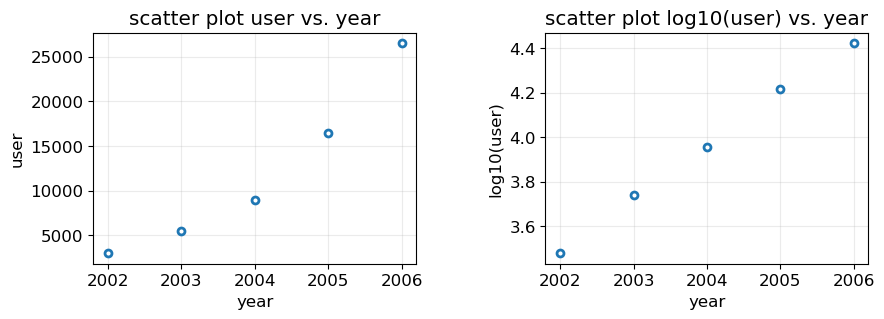

In [26]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 3))

axes[0].plot(df_scatter["Year"], df_scatter["Y"],
  marker='o', markersize=5, markerfacecolor='white',
  linestyle='None', markeredgewidth=2) 
axes[0].set_xlabel("year")
axes[0].set_ylabel("user")
axes[0].set_title("scatter plot user vs. year")
axes[0].grid("on")


axes[1].plot(df_scatter["Year"], df_scatter["log10(Y)"],
  marker='o', markersize=5, markerfacecolor='white',
  linestyle='None', markeredgewidth=2) 
axes[1].set_xlabel("year")
axes[1].set_ylabel("log10(user)")
axes[1].set_title("scatter plot log10(user) vs. year")
axes[1].grid("on")

plt.subplots_adjust(wspace=0.4)
plt.show(fig)

## Fitted line plot to $(X, \log_{10} Y)$

In [28]:
df_transform = df_scatter.copy()
df_transform['Y'] = np.log10(df_transform['Y'])
df_transform = df_transform.drop(columns=["log10(Y)"])
df_transform

,Year,X,Y
0,2002,1,3.477121
1,2003,2,3.740363
2,2004,3,3.954243
3,2005,4,4.217484
4,2006,5,4.423246


In [40]:
# compute fitted regression line
[b0_transform, b1_transform], _ = get_regress_coeff(df_transform)

# compute coefficient of determination
_, _, [SST, SSR, SSE] = get_ANOVA_table(df_transform)
rSq = SSR/SST

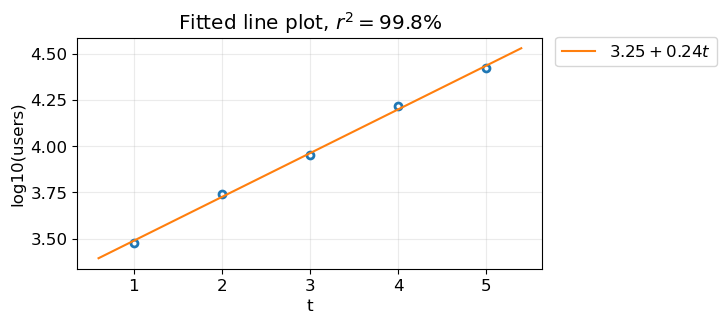

In [39]:
fig, ax = plt.subplots(figsize=(6, 3))

# Y here, has been transformed into log10(Y)
# We use the same name to reuse the function get_regress_coeff()
# and get_ANOVA_table without redefined them with different name

ax.plot(df_transform["X"], df_transform["Y"], 
  marker='o', markersize=5, markerfacecolor='white',
  linestyle='None', markeredgewidth=2) 

data_x_min = df_transform["X"].min()
data_x_max = df_transform["X"].max()
x_offset = 0.1*(data_x_max - data_x_min)
x_regress = np.linspace(data_x_min - x_offset, data_x_max + x_offset)
regress_label = r"${:.2f} + {:.2f}t$".format(b0_transform, b1_transform) \
  if b1 > 0 else r"${:.2f}{:.2f}t$".format(b0_transform, b1_transform)

ax.plot(x_regress, b0_transform + b1_transform*x_regress, 
  linestyle='-',
  label=regress_label) 

ax.set_xlabel(r"t")
ax.set_ylabel(r"log10(users)")
ax.set_title(r"Fitted line plot, $r^2={:.1f}$%".format(rSq*100))

ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.04])
ax.grid("on")
plt.show(fig)

## Forecast

In [47]:
t_forecast = 6    # year=2007

b0 = 10**(b0_transform)
b1 = 10**(b1_transform)
hat_Y_at_point = b0*(b1**t_forecast)

print(f"hat_Y (t=2007) = {round(hat_Y_at_point, -2):,.0f}")

hat_Y (t=2007) = 47,100


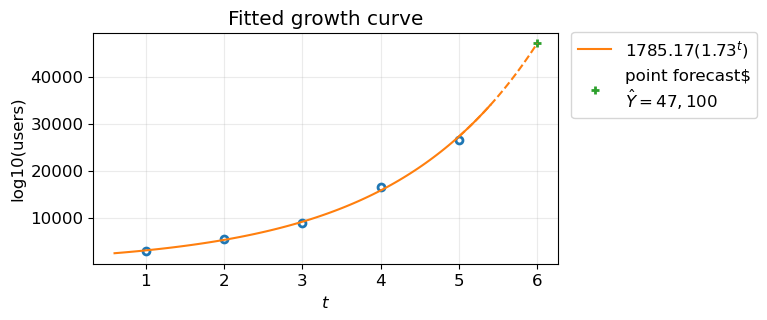

In [58]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(df_scatter["X"], df_scatter["Y"], 
  marker='o', markersize=5, markerfacecolor='white',
  linestyle='None', markeredgewidth=2) 

data_t_min = df_transform["X"].min()
data_t_max = df_transform["X"].max()
t_offset = 0.1*(data_t_max - data_t_min)
t_regress = np.linspace(data_t_min - t_offset, data_t_max + t_offset, 100)
line_handler = ax.plot(t_regress, b0 * (b1**t_regress), 
  linestyle='-',
  label=r"${:.2f}({:.2f}^t)$".format(b0, b1)) 
line_color = line_handler[0]._color

# point forecast
ax.plot([t_forecast], [hat_Y_at_point], 
  marker='+', markersize=6,
  linestyle="None", markeredgewidth=2, 
  label="point forecast$\n"+r"$\hat{Y}="+r"{:,.0f}$".format(round(hat_Y_at_point, -2)))
t_regress = np.linspace(data_t_max, t_forecast, 100)
ax.plot(t_regress, b0*(b1**t_regress), color=line_color,
  linestyle='--')

ax.set_xlabel(r"$t$")
ax.set_ylabel(r"log10(users)")
ax.set_title(r"Fitted growth curve")

ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.04])
ax.grid("on")
plt.show(fig)


## Annual growth rate

In [60]:
annual_growth_rate = (b1 - 1)

print(f"Annual growth rate = 100(b1 - 1)% = {annual_growth_rate*100:.1f}%")

Annual growth rate = 100(b1 - 1)% = 72.6%
